In [2]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn import linear_model
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
from sklearn.cross_validation import train_test_split

e:\pycharmproject\mltest\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [92]:
figsize=(12,5)
regex_a = "Survived|Age_*|SibSp|Parch_*|Fare_.*|Cabin_*|Embarked_.*|Sex_.*|Pclass.*|Age_Pclass_scaled|Age_Sex_female_scaled"
age_filter_train = ['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']
age_filter_test = ['Age','Fare', 'Parch', 'SibSp', 'Pclass']
scaler = preprocessing.StandardScaler()

In [102]:
# The model of feture Age
def set_Age_Gap(df):
    from sklearn.ensemble import RandomForestRegressor
    if("Survived" in df.columns):
        age_df = df[age_filter_train]
    else:
        age_df = df[age_filter_test]
    age_df_notnull = age_df.loc[(df['Age'].notnull())]
    age_df_isnull = age_df.loc[(df['Age'].isnull())]
    X = age_df_notnull.values[:,1:]
    Y = age_df_notnull.values[:,0]
    # use RandomForestRegression to train data
    RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    RFR.fit(X,Y)
    predictAges = RFR.predict(age_df_isnull.values[:,1:])
    df.loc[df['Age'].isnull(), ['Age']]= predictAges
    #df.loc[(df.Age.isnull()),'Age'] = df.Age.mean()
    return df

def set_Age_Discrete(df):
    tmp_age = df.Age
    factor = pd.cut(tmp_age, [0,12,70,150],labels = ['Age_young','Age_adult','Age_old'])
    dummies_age_Discrete = pd.get_dummies(factor)
    return dummies_age_Discrete


In [5]:
# The model of feture Cabin 
def set_Cabin_type(df):
    if(df.Cabin.isnull().any()):
        df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
        df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

In [6]:
# The model of Fare
def set_Scale(df,name):
    return scaler.fit_transform(df[name].values.reshape(-1,1))

In [51]:
def set_Feature(data):
    data = set_Age_Gap(data)

    data = set_Cabin_type(data)

    dummies_Cabin = pd.get_dummies(data['Cabin'], prefix= 'Cabin')

    dummies_Embarked = pd.get_dummies(data['Embarked'], prefix= 'Embarked')

    dummies_Sex = pd.get_dummies(data['Sex'], prefix= 'Sex')

    dummies_Pclass = pd.get_dummies(data['Pclass'], prefix= 'Pclass')

    b = set_Age_Discrete(data)

    df = pd.concat([data, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass, b], axis=1)

    df['Fare_scaled'] = set_Scale(df,"Fare")

    df['Age_Sex_female'] = df['Age']*df['Sex_female']
    df['Age_Sex_female_scaled'] = set_Scale(df,"Age_Sex_female")
    df['Age_Pclass'] = df['Age']*df['Pclass']
    df['Age_Pclass_scaled'] = set_Scale(df,"Age_Pclass")
    df.drop(['Age_Pclass','Age_Sex_female','Pclass','Cabin', 'Name', 'Sex', 'Ticket', 'Embarked','Fare','Age'], axis=1, inplace=True)
    
    return df

In [8]:
def get_Feature(data,regex):
    return set_Feature(data).filter(regex=regex_a)

In [9]:
def get_X_y(df):
    train_np = df.values
    X = train_np[:,1:]
    
    y = train_np[:,0]
    
    return X,y

In [111]:
data = pd.read_csv('titanic_data/train.csv')
df = get_Feature(data,regex_a)
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,1:],df.iloc[:,0],test_size=0.8,random_state=1)
#X_train

In [112]:
# 对cross validation数据进行预测
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_titanic = Pipeline([
                        ('clf',LogisticRegression(C=10.0,penalty='l2',tol=1e-6))])
pipe_titanic.fit(X_train,y_train)
pipe_titanic.score(X_test,y_test)
#pd.DataFrame({"columns":list(npp.columns)[1:], "coef":list(pipe_titanic.named_steps['clf'].coef_.T)})

0.8064516129032258

In [318]:
pipe_titanic.get_params();

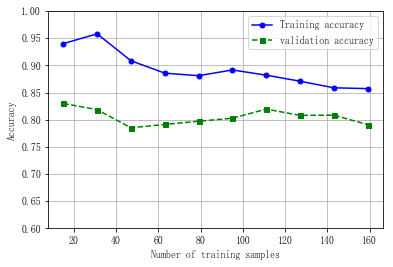

e:\pycharmproject\mltest\venv\lib\site-packages\matplotlib\mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
e:\pycharmproject\mltest\venv\lib\site-packages\matplotlib\mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


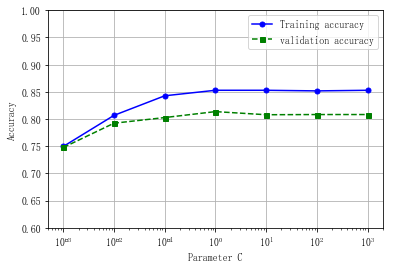

In [114]:
from sklearn.learning_curve import learning_curve
train_size, train_scores, test_scores = learning_curve(estimator=pipe_titanic,
                                                      X=X_train,
                                                      y=y_train,
                                                      train_sizes=np.linspace(0.1,1.0,10),
                                                      cv=10,
                                                      n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(train_size, train_mean,
        color = 'blue', marker='o',
        markersize=5,label = 'Training accuracy')
plt.plot(train_size, test_mean,
        color='green',linestyle='--',
        marker='s',markersize=5,
        label='validation accuracy')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = "upper right")
plt.ylim([0.6,1.0])
plt.show()

from sklearn.learning_curve import validation_curve
param_range = [0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
train_scores,test_scores=validation_curve(estimator = pipe_titanic,
                                          X = X_train,
                                          y=y_train,
                                          param_name='clf__C',
                                          param_range = param_range,
                                          cv = 6
                    )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(param_range, train_mean,
        color = 'blue', marker='o',
        markersize=5,label = 'Training accuracy')
plt.plot(param_range, test_mean,
        color='green',linestyle='--',
        marker='s',markersize=5,
        label='validation accuracy')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc = "upper right")
plt.ylim([0.6,1.0])
plt.show()

In [113]:
data_result = pd.read_csv("Titanic_data/test.csv")
data_result.loc[ (data_result.Fare.isnull()), 'Fare' ] = 0
data_pre = get_Feature(data_result,regex_a)
predictions = pipe_titanic.predict(data_pre)
result = pd.DataFrame({'PassengerId':data_result['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("Titanic_data/7+3Ageforrf.csv", index=False)